 # Structure Factor GPU Testing & Debugging



 This notebook tests and debugs the GPU-accelerated structure factor calculator.

# Setup and Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import os

# Add parent directory to path so we can import our module
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

# Import our classes
from structure_factor import StructureFactorCalculator, StructureFactorVisualizer

# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: NVIDIA GeForce RTX 3060
GPU Memory: 12.9 GB


# Create Test Data

Created test_particles_100.csv: (100, 2)
Created test_particles_1000.csv: (1000, 2)
Created test_grid_31x31.csv: (961, 2)


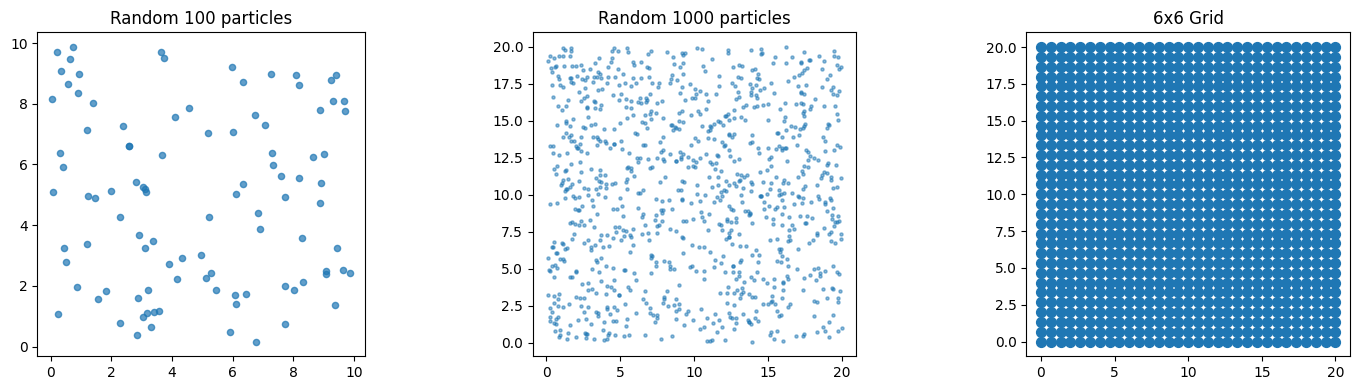

In [4]:
# Create simple test datasets
def create_test_data():
    """Create simple test particle arrangements."""
    
    # Create data directory if it doesn't exist
    os.makedirs('data', exist_ok=True)
    os.makedirs('results', exist_ok=True)
    
    # Test 1: Small random arrangement (100 particles)
    np.random.seed(42)
    particles_100 = np.random.rand(100, 2) * 10  # 10x10 area
    np.savetxt('data/test_particles_100.csv', particles_100, delimiter=',')
    print(f"Created test_particles_100.csv: {particles_100.shape}")
    
    # Test 2: Medium random arrangement (1000 particles)
    particles_1000 = np.random.rand(1000, 2) * 20  # 20x20 area
    np.savetxt('data/test_particles_1000.csv', particles_1000, delimiter=',')
    print(f"Created test_particles_1000.csv: {particles_1000.shape}")
    
    # Test 3: Simple grid for validation
    x = np.linspace(0, 20, 31)
    y = np.linspace(0, 20, 31)
    xx, yy = np.meshgrid(x, y)
    grid_particles = np.column_stack([xx.ravel(), yy.ravel()])
    np.savetxt('data/test_grid_31x31.csv', grid_particles, delimiter=',')
    print(f"Created test_grid_31x31.csv: {grid_particles.shape}")
    
    return particles_100, particles_1000, grid_particles

# Create test data
particles_100, particles_1000, grid_particles = create_test_data()

# Visualize test data
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(particles_100[:, 0], particles_100[:, 1], s=20, alpha=0.7)
axes[0].set_title('Random 100 particles')
axes[0].set_aspect('equal')

axes[1].scatter(particles_1000[:, 0], particles_1000[:, 1], s=5, alpha=0.5)
axes[1].set_title('Random 1000 particles')
axes[1].set_aspect('equal')

axes[2].scatter(grid_particles[:, 0], grid_particles[:, 1], s=50)
axes[2].set_title('6x6 Grid')
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()


# Test Calculator Class

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import os

# Add parent directory to path so we can import our module
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

# Import our classes
from structure_factor import StructureFactorCalculator, StructureFactorVisualizer

calculator = StructureFactorCalculator(memory_fraction=0.01)
calculator.calculate_and_save(
    read_folder='./data/',
    filename='test_grid_31x31',
    range_calculation=5.0,
    vector_step=0.1,
    save_folder='./results/',
    full_plane=True
)

2025-08-10 19:42:21,881 - INFO - Processing file: test_grid_31x31
2025-08-10 19:42:21,884 - INFO - Structure analysis: 961 particles, avg neighbor distance: 0.666666
2025-08-10 19:42:21,895 - INFO - Selected structure factor calculation method: iterative
2025-08-10 19:42:21,896 - INFO - q-range: -7500005.50 µm⁻¹ to 7350004.00 µm⁻¹
2025-08-10 19:42:21,896 - INFO - S(q) progress: 1/100 (1.0%)
c:\Users\Gil\Documents\GitHub\portfolio\PhD\Analysis\structure_factor.py:156: ComplexWarning: Casting complex values to real discards the imaginary part
  structure_factor[a,b] = (1/N)*np.sum(np.exp(1j*(q[a]*d_x + q[b]*d_y)))
2025-08-10 19:42:25,595 - INFO - S(q) progress: 2/100 (2.0%)
2025-08-10 19:42:29,243 - INFO - S(q) progress: 3/100 (3.0%)
2025-08-10 19:42:32,844 - INFO - S(q) progress: 4/100 (4.0%)
2025-08-10 19:42:36,429 - INFO - S(q) progress: 5/100 (5.0%)
2025-08-10 19:42:40,041 - INFO - S(q) progress: 6/100 (6.0%)
2025-08-10 19:42:43,664 - INFO - S(q) progress: 7/100 (7.0%)
2025-08-10 19:

KeyboardInterrupt: 

# Test Vector Generation

In [ ]:
# Test vector generation
import torch

structure_tensor = torch.from_numpy(test_structure)
d_x, d_y, q = calculator.generate_vectors(structure_tensor, 5.0, 0.5, D)

print(f"Distance arrays shape: d_x {d_x.shape}, d_y {d_y.shape}")
print(f"Q-vector shape: {q.shape}")
print(f"Q-vector range: [{q[0]:.3f}, {q[-1]:.3f}] (normalized)")
print(f"Q-vector range: [{q[0]*D:.3f}, {q[-1]*D:.3f}] (physical)")


# GPU Memory Check

In [ ]:
def check_gpu_memory_usage(n_particles, q_points):
    """Estimate GPU memory usage for given parameters."""
    
    # Distance arrays: 2 * (1, N²) * 4 bytes (float32)
    distance_memory = 2 * n_particles**2 * 4
    
    # Q-vector: q_points * 4 bytes
    q_memory = q_points * 4
    
    # Structure factor result: (q_points, q_points) * 8 bytes (complex64)
    result_memory = q_points**2 * 8
    
    total_memory = distance_memory + q_memory + result_memory
    
    print(f"Memory estimate for {n_particles} particles, {q_points} q-points:")
    print(f"  Distance arrays: {distance_memory/1e6:.1f} MB")
    print(f"  Q-vector: {q_memory/1e3:.1f} KB")
    print(f"  Result array: {result_memory/1e6:.1f} MB")
    print(f"  Total: {total_memory/1e6:.1f} MB")
    
    if torch.cuda.is_available():
        available_memory = torch.cuda.get_device_properties(0).total_memory
        print(f"  Available GPU memory: {available_memory/1e9:.1f} GB")
        print(f"  Memory usage: {total_memory/available_memory*100:.1f}%")
    
    return total_memory

# Check memory for different sizes
check_gpu_memory_usage(100, 10)   # Small test
print()
check_gpu_memory_usage(1000, 20)  # Medium test
print()
check_gpu_memory_usage(5000, 50)  # Large test


# Test Visualizer Class

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: xlabel='qx (m⁻¹)', ylabel='qy (m⁻¹)'>)

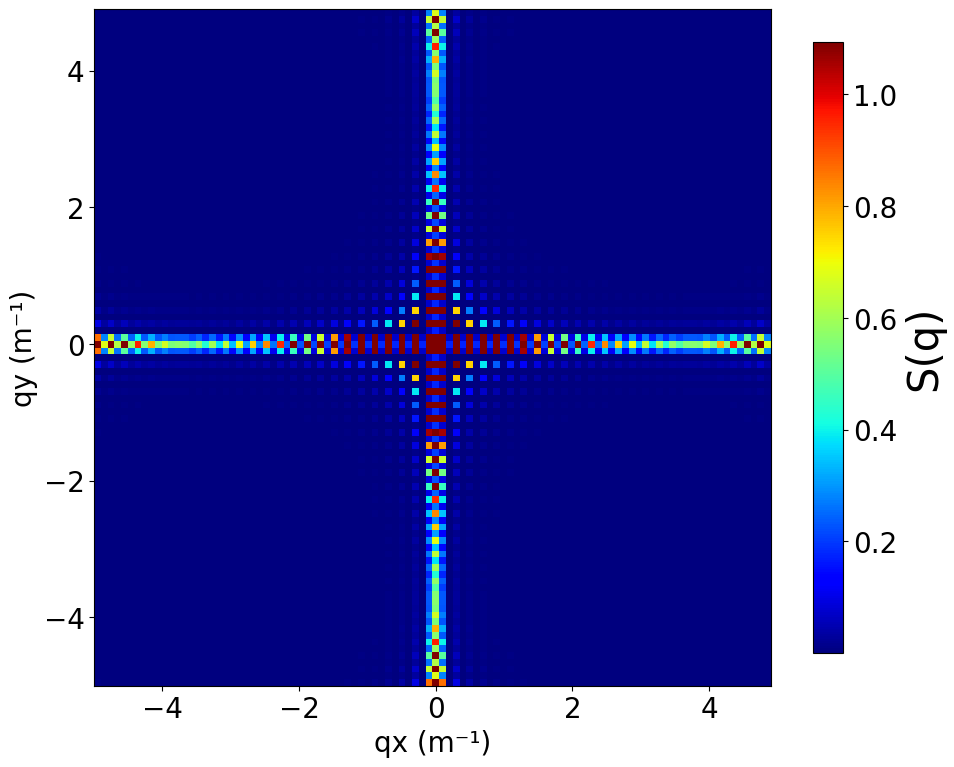

In [6]:
import sys
import os

# Add parent directory to path so we can import our module
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from structure_factor import StructureFactorVisualizer

visualizer = StructureFactorVisualizer()

visualizer.plot_Sq_2D(
            data_folder='./results',
            filename='sq2d-test_grid_31x31-qD-5.000-4.900-dq0.100-t20250810T171839Z',
            plot_range=(0,9),
            coordinate_system='qD', 
            save_plot=False,
            auto_contrast=True,
            output_folder='./figures'
        )

INFO:structure_factor:Saved 1D figure: figures/1D_Sq_test_particles_1000_range_9_step_0.3_20250807T192923_range_0_9.png


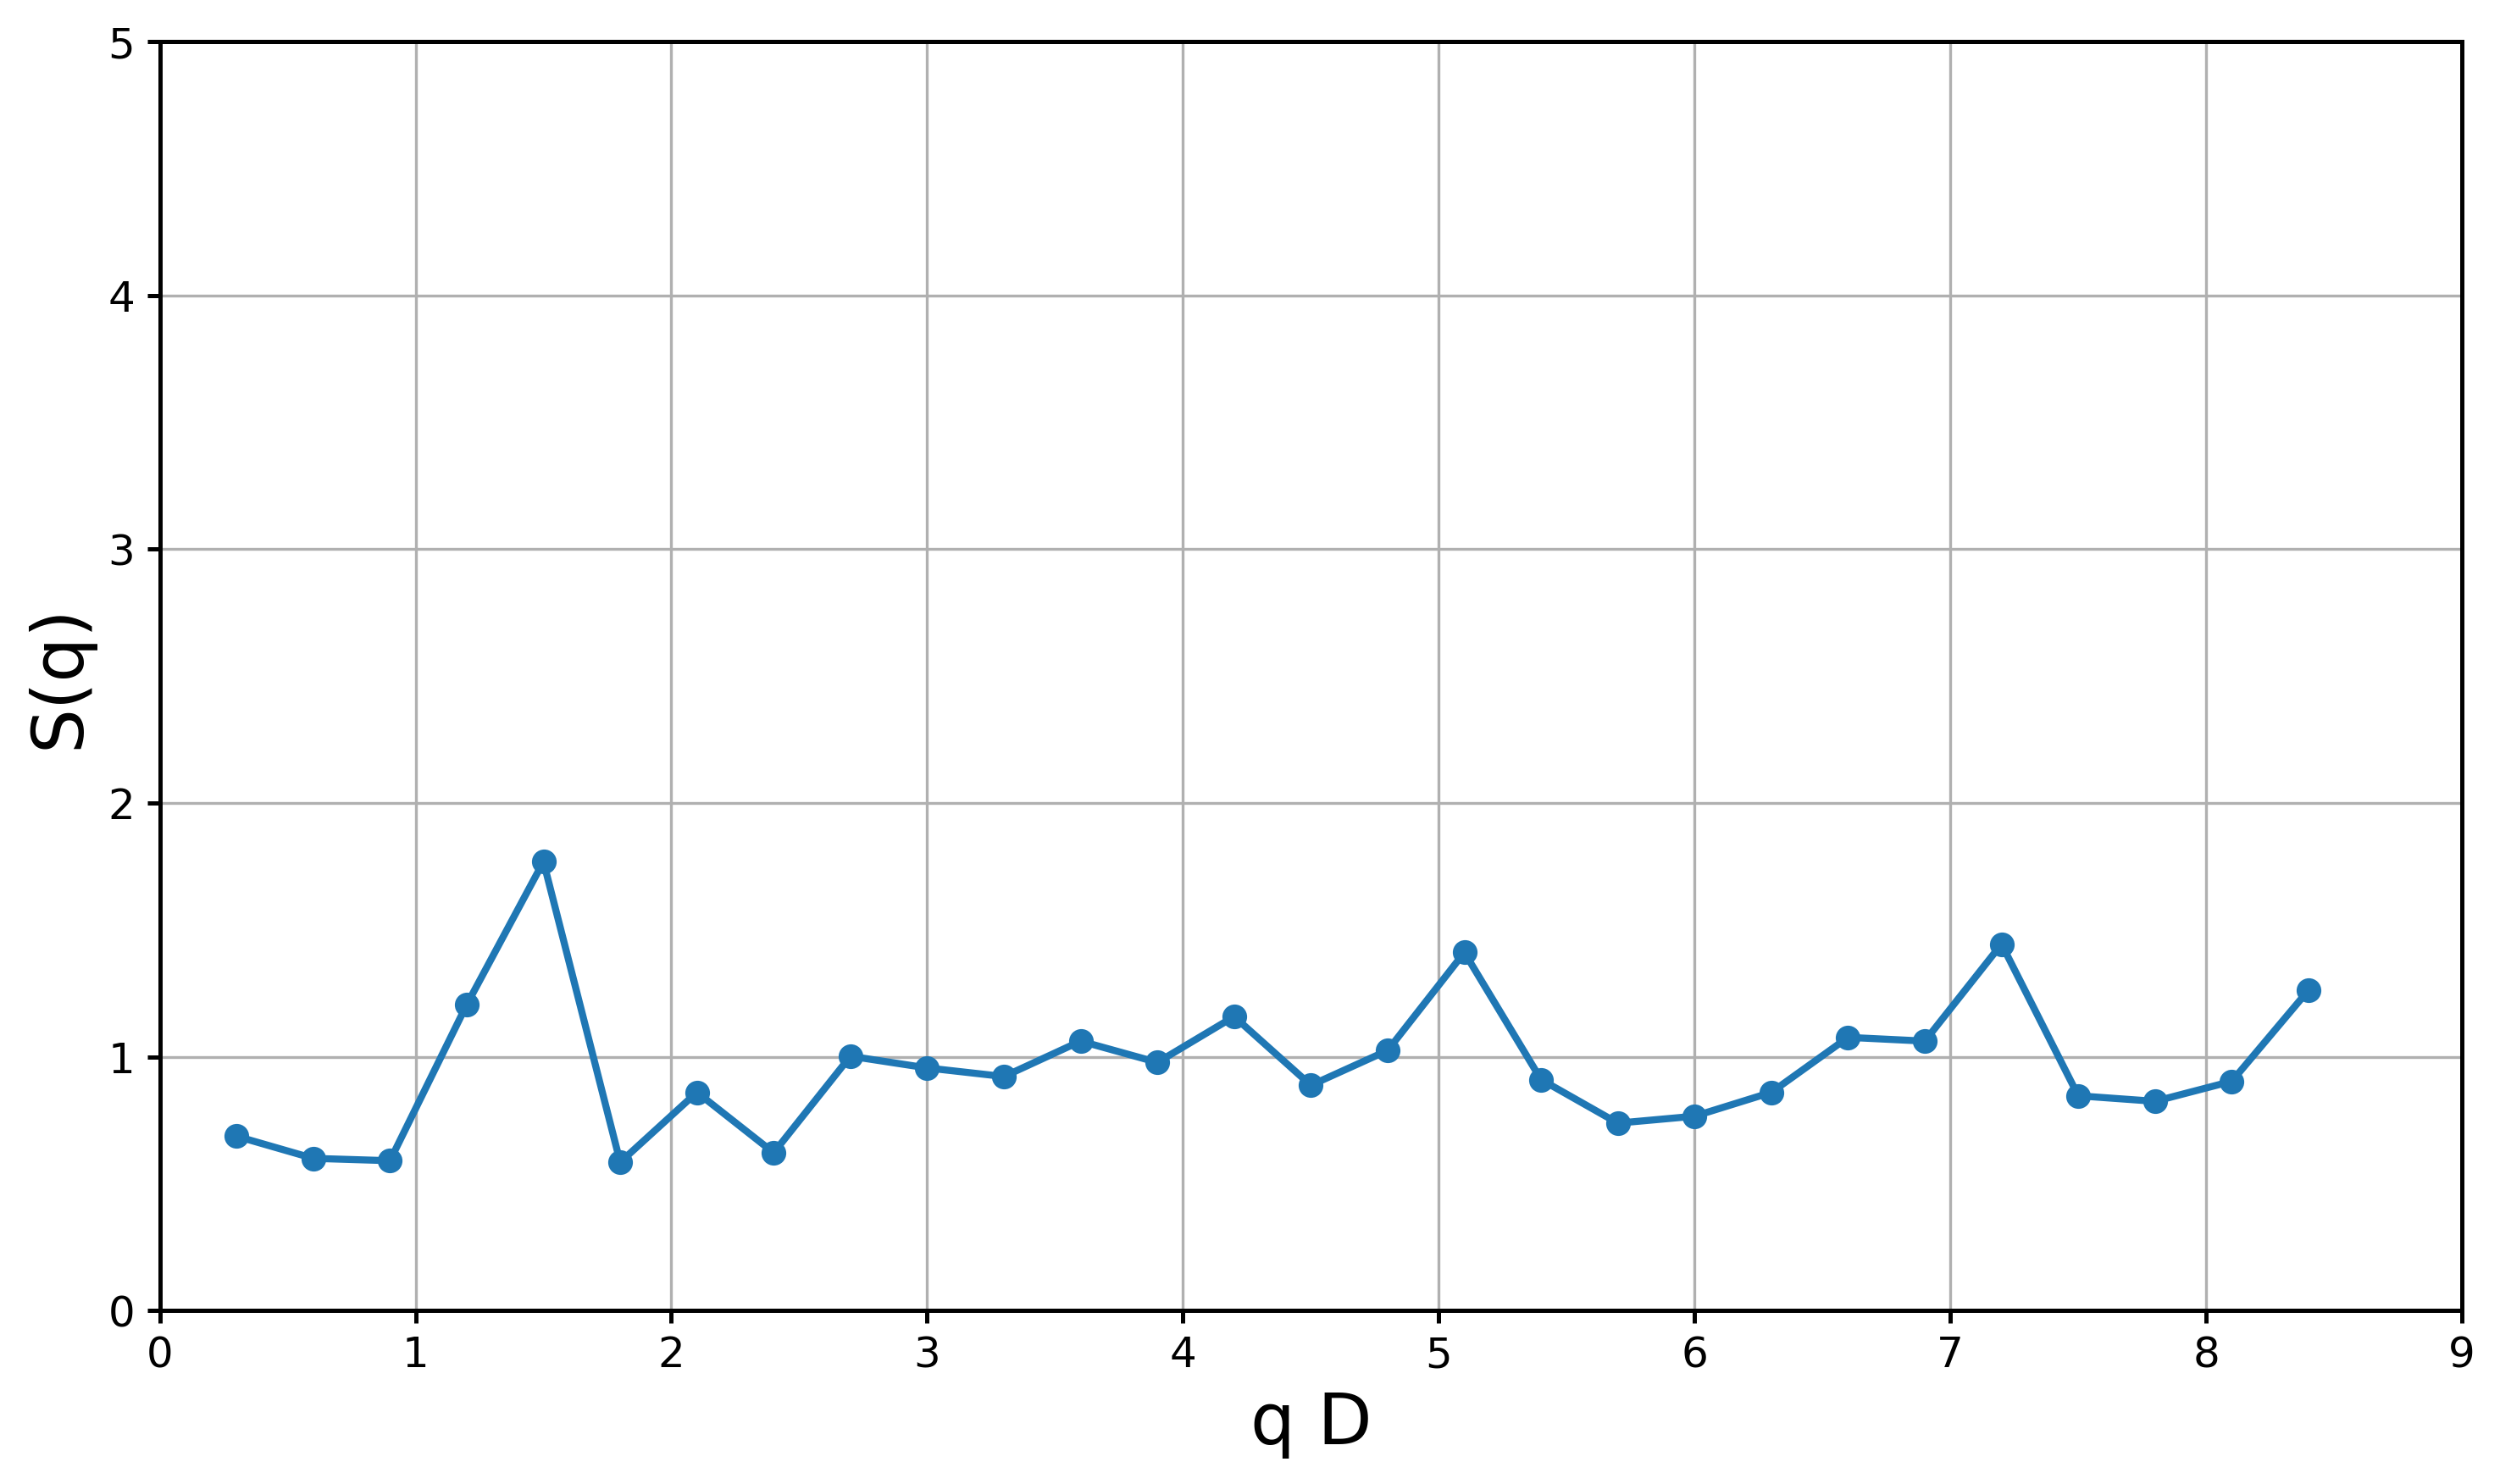

In [2]:
visualizer.plot_1d_structure_factor(
            data_folder='./output',
            filename='test_particles_1000_range_9_step_0.3_20250807T192923',
            plot_range=(0,9),
            coordinate_system='qD',
            save_plot=True,
            output_folder='./figures'
        )

# Performance Comparison (CPU vs GPU)

In [ ]:
import time

def benchmark_calculation(n_particles, q_points, use_gpu=True):
    """Simple benchmark of calculation speed."""
    
    # Create test data
    test_data = np.random.rand(n_particles, 2) * 10
    np.savetxt('data/benchmark_test.csv', test_data, delimiter=',')
    
    # Calculate parameters
    D, N = calculator.get_calculation_parameters(test_data)
    
    # Generate vectors
    structure_tensor = torch.from_numpy(test_data)
    d_x, d_y, q = calculator.generate_vectors(structure_tensor, 5.0, 5.0/q_points, D)
    
    # Move to appropriate device
    device = 'cuda' if (use_gpu and torch.cuda.is_available()) else 'cpu'
    d_x = d_x.to(device)
    d_y = d_y.to(device)
    q = q.to(device)
    N_tensor = torch.tensor(N, dtype=torch.float).to(device)
    
    print(f"Benchmarking {n_particles} particles, {len(q)} q-points on {device}")
    
    # Time the calculation (just a few q-points for speed)
    start_time = time.time()
    
    # Calculate just a small portion for timing
    n_test = min(3, len(q))  # Test first 3x3 q-points
    structure_factor = torch.zeros((n_test, n_test), device=device)
    
    for a in range(n_test):
        for b in range(n_test):
            structure_factor[a,b] = (1/N_tensor)*torch.sum(torch.exp(1j*(q[a]*d_x + q[b]*d_y)))
    
    end_time = time.time()
    calculation_time = end_time - start_time
    
    # Extrapolate to full calculation
    full_time_estimate = calculation_time * (len(q)/n_test)**2
    
    print(f"  Partial calculation time: {calculation_time:.3f} seconds")
    print(f"  Full calculation estimate: {full_time_estimate:.1f} seconds")
    
    return calculation_time, full_time_estimate

# Run benchmarks
print("Performance Benchmarking:")
print("=" * 50)

# Small test
cpu_time, cpu_full = benchmark_calculation(100, 10, use_gpu=False)
if torch.cuda.is_available():
    gpu_time, gpu_full = benchmark_calculation(100, 10, use_gpu=True)
    speedup = cpu_time / gpu_time
    print(f"  Speedup: {speedup:.1f}x")
else:
    print("  GPU not available for comparison")
